## Modelos $SIS$ y $SIR$ con natalidad y mortalidad

Al igual que en los modelos anteriores, antes de describir las reglas de evolución que implementamos debemos conocer la manera en la que se modelan las tasas de natalidad y mortalidad en los modelos $SIS$ y $SIR$ clásicos.

### El modelo $SIS$ con natalidad y mortalidad

Para este modelo consideraremos un nuevo "estado", el estado $D$, con el cual identificaremos los agentes que mueren y a los agentes que pueden entrar (nacer) en el sistema, es decir, un individuo que pasa a poseer la cualidad $D$ será considerado como un individuo que murió (tomando una tasa de mortalidad $\mu_2$). Por otro lado, si para un tiempo $t$ el estado de un agente es $D$, el agente tendrá únicamente dos posibilidades, mantenerse en el estado $D$ o cambiar al estado $S$.

El estado $D$ funciona como un estado de "espera o receso" de la interacción entre susceptibles e infectados, con la condición de que los individuos que salgan de tal "receso" pasen a poseer únicamente el estado $S$. La implementación del estado $D$ nos permitirá simular la muerte y el nacimiento de un individuo.

Para poder implementar esta noción de mortalidad y natalidad debemos incluir mas parámetros para la evolución de los agentes:

*   **La edad:** Para poder implementar la idea de esperanza de vida de un agente debemos añadir un contador que corresponda con la edad del agente. Al definir la condición inicial del sistema se incluyo un valor entero a cada píxel que corresponderá con la edad del agente a los individuos que les sea asignado el valor cero los identificaremos con el estado $D$. De acuerdo con la medida de tiempo que estemos usando, podremos ajustar el contador de edad.
*   **Tasas de mortalidad por grupo de edad:** Para nuestra implementación incluimos probabilidades de muerte por grupos de edad, esto nos permitirá realizar análisis mas detallados sobre una enfermedad especifica. Estas probabilidades se aplicarán a todos los individuos que cuenten con un estado distinto de $D$ y $V$ (el estado identificado con el color negro). Cada individuo que "muera" pasará a adquirir el estado $D$ independientemente del estado previo a su "muerte".
*   **Tasa de natalidad:** Esta tasa se aplicará únicamente sobre los píxeles con el estado $D$, el uso de este parámetro será exclusivamente para simular el paso del estado $D$ al estado $S$ (podemos interpretar esta interacción como un nacimiento de un agente). Si se realiza tal transición, la edad del píxel será 1.

La manera en la que implementamos cada uno de los conceptos anteriormente definidos, se describe mediante el siguiente diagrama:

In [16]:
system1 = np.zeros((10,10))
ranges = [[1,25,0.4],[25,64,0.4],[65,90,0.2]]
ages_sys1 = agesMatrix(ranges,system1)
ages_sys1

array([[58., 47., 88., 42., 47., 54., 70., 45.,  9.,  8.],
       [36., 25.,  3., 24., 36., 22., 45., 44.,  8., 51.],
       [82., 10., 85.,  4., 10., 12.,  4., 62., 82., 70.],
       [13., 85., 56., 62., 52., 58., 12., 19., 12., 26.],
       [85., 56., 41., 58.,  3.,  9., 11., 85., 63., 36.],
       [85., 47.,  3., 68.,  8., 54., 12., 42., 31., 58.],
       [51.,  7., 59., 22., 20., 34.,  2., 45., 11., 88.],
       [41., 58., 47., 71., 19., 25.,  3., 29., 56.,  5.],
       [85., 56., 54.,  2., 44., 18., 56., 62., 20., 11.],
       [84., 25., 34., 19., 20., 45., 77., 19.,  3., 88.]])

Consideraremos ahora un sistema no lineal con 100 individuos, de los cuales el $40\%$ es menor de 25 años, el $40\%$ tiene ente 25 y 64 años y el $20\%$ es mayor de 65 años. Por otro lado, suponemos que los individuos menores de 15 años tienen una probabilidad del $0.05\%$ de morir, los que tienen entre 15 y 69 años del $2\%$ y los mayores de 70 del $15\%$.

*   **La enfermedad E:** Cuenta con una tasa de recuperación del $20\%$ y una tasa de infección del $5\%$. 
*   **La enfermedad F:** Posee una tasa de infección del $50\%$ y al igual que la enfermedad E, cuenta con una tasa de recuperación del $20\%$.

Se consideró una población inicial infectada del $10\%$, además por cada individuo en promedio "nacen" 2 agentes. Una vez dicho esto, analizamos la evolución de la enfermedad en un periodo de 200 días.

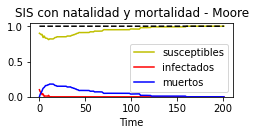

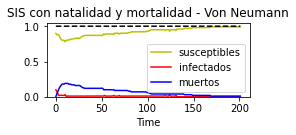

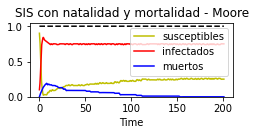

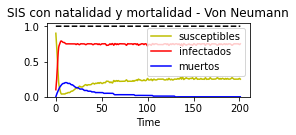

In [17]:
system1 = initialCondition(0.1,np.zeros((10,10)))
ranges = [[1,25,0.4],[25,64,0.4],[65,90,0.2]]
ages_sys1 = agesMatrix(ranges,system1)

mr = [[1,14,0.0005],[15,69,0.02],[70,100,0.15]]
br = 2

plt.subplot(2,2,1)
sm_1 = models("sis_birthAndMortavility",0.2,0.05,system1,Moore)
sm_1.birthRate = br; sm_1.probabilityOfDyingByAgeGroup = mr
sm_1.systemAges = ages_sys1; sm_1.annualUnit = 365
sm_1.metricsPlot(200,"SIS con natalidad y mortalidad - Moore")

plt.subplot(2,2,2)
svn_1 = models("sis_birthAndMortavility",0.2,0.05,system1,Von_Neumann)
svn_1.birthRate = br; svn_1.probabilityOfDyingByAgeGroup = mr
svn_1.systemAges = ages_sys1; svn_1.annualUnit = 365
svn_1.metricsPlot(200,"SIS con natalidad y mortalidad - Von Neumann")

plt.subplot(2,2,1)
sm_2 = models("sis_birthAndMortavility",0.2,0.5,system1,Moore)
sm_2.birthRate = br; sm_2.probabilityOfDyingByAgeGroup = mr
sm_2.systemAges = ages_sys1; sm_2.annualUnit = 365
sm_2.metricsPlot(200,"SIS con natalidad y mortalidad - Moore")

plt.subplot(2,2,2)
svn_2 = models("sis_birthAndMortavility",0.2,0.5,system1,Von_Neumann)
svn_2.birthRate = br; svn_2.probabilityOfDyingByAgeGroup = mr
svn_2.systemAges = ages_sys1; svn_2.annualUnit = 365
svn_2.metricsPlot(200,"SIS con natalidad y mortalidad - Von Neumann")

![texto del enlace](https://docs.google.com/drawings/d/e/2PACX-1vS7ICHAzGgiDie9tsl0_laD-fNVN2ROSMcWion5EpqYs_c6qqvxM3QhCi7xKT_naHQRGdzwzAdx_HXr/pub?w=697&h=516)

Observe que la enfermedad B termina desapareciendo, mientras que la enfermedad F se convierte en una endemia. Esto se debe a que los parámetros en el caso de la enfermedad E y en el contexto del modelo $SIS$ clásico, implican que la enfermedad termina desapareciendo mientras que en el caso de la enfermedad F ocurre todo lo contrario.

### El modelo $SIR$ con natalidad y mortalidad

Al igual que en el modelo anterior, implementamos la noción de estado de receso o "muerte", identificaremos este estado de receso con la letra $D$, el siguiente diagrama nos permitirá comprender la manera en la que se construye el modelo $SIR$ con natalidad y mortalidad:

Para poder diseñar las reglas de evolución que gobiernan el comportamiento del modelo $SIR$ con natalidad y mortalidad, implementamos las nociones de edad, tasas de natalidad y mortalidad por grupos de edad descritas anteriormente. Adicionalmente, se tomo en cuenta la regla de evolución para AC con edades (ver el esquema para la evolución de sistemas con edades) para modelar correctamente la evolución de esta característica.

Consideremos ahora dos sistemas no lineales con 100 individuos cada uno, ambas poblaciones se agrupan en tres grandes grupos de edad: Un $40\%$ son menores de 25 años, un $20\%$ son mayores de 65 años y el $40\%$ restante corresponde con los individuos que tienen entre 25 y 64 años. Supondremos además que los menores de 15 años tienen una probabilidad de morir del $0.05\%$, los mayores de 70 un $15\%$ y los que tienen entre 15 y 69 una probabilidad de fallecimiento del $2\%$.

*   **La enfermedad G:** Posee una tasa de infección del $5\%$ ($\beta=0.05$) y una tasa de recuperación $\alpha$ del $20\%$. Esta enfermedad afecta únicamente al primer sistema, el cual cuenta con un promedio de 2 nacimientos por individuo.
*   **La enfermedad H:** Posee las mismas características que la enfermedad G, con la diferencia de que su tasa de infección es del $50\%$ y afecta únicamente al segundo sistema.

Analizamos el comportamiento de cada enfermedad en un periodo de 200 días sobre sistemas del tipo cuadrado, considerando una población infectada inicial del $10\%$.

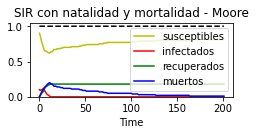

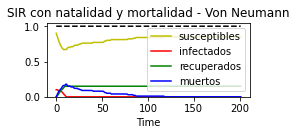

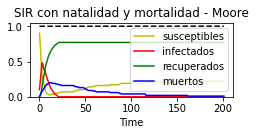

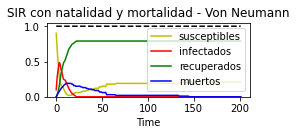

In [18]:
system1 = initialCondition(0.1,np.zeros((10,10)))
ranges = [[1,25,0.4],[25,64,0.4],[65,90,0.2]]
ages_sys1 = agesMatrix(ranges,system1)

mr = [[1,14,0.0005],[15,69,0.02],[70,100,0.15]]
br = 2

plt.subplot(2,2,1)
sm_1 = models("sir_birthAndMortavility",0.2,0.05,system1,Moore)
sm_1.birthRate = br; sm_1.probabilityOfDyingByAgeGroup = mr
sm_1.systemAges = ages_sys1; sm_1.annualUnit = 365
sm_1.metricsPlot(200,"SIR con natalidad y mortalidad - Moore")

plt.subplot(2,2,2)
svn_1 = models("sir_birthAndMortavility",0.2,0.05,system1,Von_Neumann)
svn_1.birthRate = br; svn_1.probabilityOfDyingByAgeGroup = mr
svn_1.systemAges = ages_sys1; svn_1.annualUnit = 365
svn_1.metricsPlot(200,"SIR con natalidad y mortalidad - Von Neumann")

plt.subplot(2,2,1)
sm_2 = models("sir_birthAndMortavility",0.2,0.5,system1,Moore)
sm_2.birthRate = br; sm_2.probabilityOfDyingByAgeGroup = mr
sm_2.systemAges = ages_sys1; sm_2.annualUnit = 365
sm_2.metricsPlot(200,"SIR con natalidad y mortalidad - Moore")

plt.subplot(2,2,2)
svn_2 = models("sir_birthAndMortavility",0.2,0.5,system1,Von_Neumann)
svn_2.birthRate = br; svn_2.probabilityOfDyingByAgeGroup = mr
svn_2.systemAges = ages_sys1; svn_2.annualUnit = 365
svn_2.metricsPlot(200,"SIR con natalidad y mortalidad - Von Neumann")

![texto del enlace](https://docs.google.com/drawings/d/e/2PACX-1vS9K4WcfOM2kgpaR0aK4xUglFZRIjD79Zg1RAiZw9DCGbOXddZfMvEQgBtLTPg8aY_Iea-GL229ZtnI/pub?w=703&h=526)

Al igual que como ocurrió en el caso de las enfermedades E y F en el modelo $SIS$ con natalidad y mortalidad, la enfermedad G termina desapareciendo al poco tiempo de iniciar el estudio mientras que la enfermedad alcanza un pico en las primeras semanas para desaparecer posteriormente. Estos comportamientos se deben a los valores de los parámetros que definen cada enfermedad y a sus implicaciones en el modelo $SIR$ clásico.

## Modelos $SIS$ y $SIR$ con muerte por enfermedad

Para construir las reglas de evolución de ambos modelos $SIS$ y $SIR$ con muerte por enfermedad, decidimos implementar los conceptos de edad, tasas de natalidad y mortalidad por grupo de edad e implementarlos de la misma manera que en la sección anterior, adicionalmente implementamos un tipo de tasas que se comporta de manera similar a las tasas de mortalidad por grupo de edad, sin embargo estás afectarán únicamente al estado de infección. A continuación podremos visualizar de manera general, la manera en la que se implementaron las *tasas de mortalidad por enfermedad por grupo de edad*:

### El modelo $SIS$ con muerte por enfermedad

El siguiente diagrama nos ayudará a comprender la manera en la que se implementaron las reglas de evolución para el modelo $SIS$ con muerte por enfermedad:

Donde al igual que en los modelos con natalidad y mortalidad, identificamos a las tasas de mortalidad por grupo de edad con $\mu_2$ y la tasa de natalidad con $\mu_1$, identificaremos además a la tasa de mortalidad por enfermedad por grupo de edad con la letra griega $\theta$.

A continuación analizaremos dos casos particulares, cada uno de ellos definidos con parámetros $\alpha$ y $\beta$ de modo que al analizarlos en el contexto del modelo clásico obtengamos valores para el indicador $R_0$ mayor y menor a la unidad, recordando que $R_0=\frac{\beta}{\alpha}$.

Partiremos de dos sistemas no lineales, cada uno de 100 individuos de modo que el $40\%$ es menor de 25 años, un $20\%$ es mayor de 65 años y el $40\%$ corresponde a los individuos que tienen entre 25 y 64 años, supondremos que por cada individuo nacen en promedio 2 agentes y que las probabilidades de muerte por grupo de edad estarán dadas por la siguiente tabla:

*   **La enfermedad I:** Posee una tasa de infección $\beta$ del $5\%$ y una tasa de recuperación $\alpha=0.2$, esta enfermedad esta presente únicamente en el primer sistema y afecta principalmente a individuos mayores de 79 años, llegando a ocasionarles la muerte en un $80\%$ de los casos, tenemos también a los individuos que tienen entre 46 y 78 años, para este grupo tenemos una probabilidad del $35\%$ de fallecimiento, mientras que para los que tienen entre 21 y 45 años tenemos el $15\%$, por último tenemos a los menores de 21 años, los cuales tienen una probabilidad del $8\%$ de morir por causa de la enfermedad.
*   **La enfermedad J:** Afecta únicamente al segundo sistema y actúa de manera similar a la enfermedad I, con la diferencia de que su tasa de contagio $\beta$ es del $50\%$.

Analizamos el comportamiento de ambas enfermedades sobre un sistema cuadrado en un periodo de 200 días, obteniendo así los siguientes resultados:

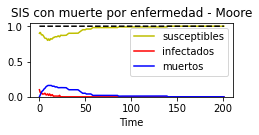

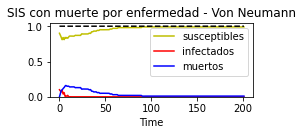

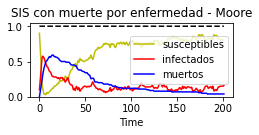

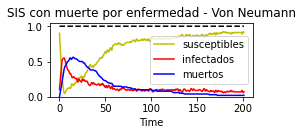

In [19]:
system3 = initialCondition(0.1,np.zeros((10,10)))

ranges = [[1,25,0.4],[25,64,0.4],[65,90,0.2]]
mr = [[1,14,0.0005],[15,69,0.02],[70,100,0.15]]
br = 2
ages_sys3 = agesMatrix(ranges,system3)
ranges_dead = [[1,20,0.08],[21,45,0.15],[46,78,0.35],[79,100,0.8]]

plt.subplot(2,2,1)
sm_1 = models("sis_deathByDisease",0.2,0.05,system3,Moore)
sm_1.birthRate = br; sm_1.probabilityOfDyingByAgeGroup = mr
sm_1.deathFromDiseaseByAgeRange = ranges_dead
sm_1.systemAges = ages_sys3; sm_1.annualUnit = 365
sm_1.metricsPlot(200,"SIS con muerte por enfermedad - Moore")

plt.subplot(2,2,2)
svn_1 = models("sis_deathByDisease",0.2,0.05,system3,Von_Neumann)
svn_1.birthRate = br; svn_1.probabilityOfDyingByAgeGroup = mr
svn_1.deathFromDiseaseByAgeRange = ranges_dead
svn_1.systemAges = ages_sys3; svn_1.annualUnit = 365
svn_1.metricsPlot(200,"SIS con muerte por enfermedad - Von Neumann")

plt.subplot(2,2,3)
sm_2 = models("sis_deathByDisease",0.2,0.5,system3,Moore)
sm_2.birthRate = br; sm_2.probabilityOfDyingByAgeGroup = mr
sm_2.deathFromDiseaseByAgeRange = ranges_dead
sm_2.systemAges = ages_sys3; sm_2.annualUnit = 365
sm_2.metricsPlot(200,"SIS con muerte por enfermedad - Moore")

plt.subplot(2,2,4)
svn_2 = models("sis_deathByDisease",0.2,0.5,system3,Von_Neumann)
svn_2.birthRate = br; svn_2.probabilityOfDyingByAgeGroup = mr
svn_2.deathFromDiseaseByAgeRange = ranges_dead
svn_2.systemAges = ages_sys3; svn_2.annualUnit = 365
svn_2.metricsPlot(200,"SIS con muerte por enfermedad - Von Neumann")

![texto del enlace](https://docs.google.com/drawings/d/e/2PACX-1vSeipC9HyWTQ0ofIow4P1kmGjZQG9Britw9ct-y0sbOoXYi5GePAN4Aav0NCsA6W1xflLYAJzZH4gkd/pub?w=706&h=515)

Podemos observar que en el caso de la enfermedad I, debido al valor $R_0$ en el contexto del modelo $SIS$ clásico, implica la desaparición de la enfermedad $R_0=\frac{\beta}{\alpha}< 1$. Por otro lado tenemos a la enfermedad J, en donde $R_0>1$ implicando una posible endemia, la cual es evidenciada en la figura b.

### El modelo $SIR$ con muerte por enfermedad

Usando la notación que se definió para el modelo $SIS$ con muerte por enfermedad, podemos entender el comportamiento del modelo $SIR$ con muerte por enfermedad como se muestra en el siguiente diagrama:

Recordemos que en el caso del modelo $SIR$ clásico, si para una enfermedad particular teníamos un valor de $R_0$ menor que la unidad, está terminaría desapareciendo poco después de iniciar el estudio. Por otro lado si $R_0>1$, la enfermedad alcanzaría un pico para posteriormente tender a su punto de equilibrio [1]. Teniendo esto en mente, analizaremos dos enfermedades de modo que los parámetros que las definan, nos permitan visualizar la manera en que se implementaron las reglas para el modelo $SIR$ con muerte por enfermedad y sus implicaciones para el análisis epidemiológico.

Al igual que en el modelo $SIS$ con muerte por enfermedad, partiremos de dos sistemas no lineales, cada uno de 100 individuos de modo que el $40\%$ es menor de 25 años, un $20\%$ es mayor de 70 años y el $40\%$ corresponde a los individuos que tienen entre 15 y 69 años, supondremos que por cada individuo nacen en promedio 2 agentes y que las probabilidades de muerte por grupo de edad estarán dadas por la siguiente tabla:

*   **La enfermedad K:** Posee una tasa de recuperación del $20\%$ y tasa de infección $\beta$ del $5\%$, esta enfermedad esta presente únicamente en el primer sistema afectando principalmente a individuos mayores de 79 años, llegando a ocasionarles la muerte en un $80\%$ de los casos, tenemos también a los individuos que tienen entre 46 y 78 años, para este grupo tenemos una probabilidad del $35\%$ de fallecimiento, mientras que para los que tienen entre 21 y 45 años tenemos el $15\%$, por último tenemos a los menores de 21 años, los cuales tienen una probabilidad del $8\%$ de morir por causa de la enfermedad.
*   **La enfermedad L:** Afecta únicamente al segundo sistema, actuando de manera similar que la enfermedad K con la diferencia de que su tasa de infección $\beta$ es del $50\%$.

Analizamos el comportamiento de ambas enfermedades en un periodo de 200 días, sobre dos sistemas cuadrados tomando como población infectada a un $10\%$ de la población.

Del lado izquierdo de la siguiente figura podremos observar el comportamiento de la enfermedad K, resaltando la idea de que su evolución se debe a la naturaleza de los parámetros que definen tal enfermedad ($\alpha$ y $\beta$ son tales que $R_0=\frac{\beta}{\alpha}< 1$), del mismo modo para la enfermedad L (en esta caso $R_0=\frac{\beta}{\alpha}> 1$).

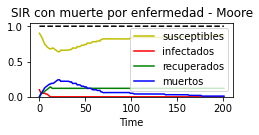

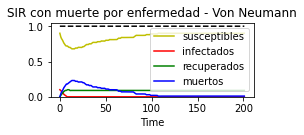

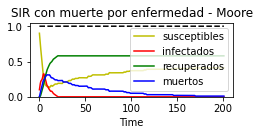

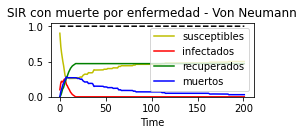

In [20]:
system3 = initialCondition(0.1,np.zeros((10,10)))

ranges = [[1,25,0.4],[25,64,0.4],[65,90,0.2]]
mr = [[1,14,0.0005],[15,69,0.02],[70,100,0.15]]
br = 2
ages_sys3 = agesMatrix(ranges,system3)
ranges_dead = [[1,20,0.08],[21,45,0.15],[46,78,0.35],[79,100,0.8]]

plt.subplot(2,2,1)
sm_1 = models("sir_deathByDisease",0.2,0.05,system3,Moore)
sm_1.birthRate = br; sm_1.probabilityOfDyingByAgeGroup = mr
sm_1.deathFromDiseaseByAgeRange = ranges_dead
sm_1.systemAges = ages_sys3; sm_1.annualUnit = 365
sm_1.metricsPlot(200,"SIR con muerte por enfermedad - Moore")

plt.subplot(2,2,2)
svn_1 = models("sir_deathByDisease",0.2,0.05,system3,Von_Neumann)
svn_1.birthRate = br; svn_1.probabilityOfDyingByAgeGroup = mr
svn_1.deathFromDiseaseByAgeRange = ranges_dead
svn_1.systemAges = ages_sys3; svn_1.annualUnit = 365
svn_1.metricsPlot(200,"SIR con muerte por enfermedad - Von Neumann")

plt.subplot(2,2,3)
sm_2 = models("sir_deathByDisease",0.2,0.5,system3,Moore)
sm_2.birthRate = br; sm_2.probabilityOfDyingByAgeGroup = mr
sm_2.deathFromDiseaseByAgeRange = ranges_dead
sm_2.systemAges = ages_sys3; sm_2.annualUnit = 365
sm_2.metricsPlot(200,"SIR con muerte por enfermedad - Moore")

plt.subplot(2,2,4)
svn_2 = models("sir_deathByDisease",0.2,0.5,system3,Von_Neumann)
svn_2.birthRate = br; svn_2.probabilityOfDyingByAgeGroup = mr
svn_2.deathFromDiseaseByAgeRange = ranges_dead
svn_2.systemAges = ages_sys3; svn_2.annualUnit = 365
svn_2.metricsPlot(200,"SIR con muerte por enfermedad - Von Neumann")

![texto del enlace](https://docs.google.com/drawings/d/e/2PACX-1vQAQhw8uEQOJCa-UQYcGvsUBeWWjJyVes7EzzamTtEt9upxxyzl0AyQ23yrh9e-CVnUVStOAa7IJcxI/pub?w=694&h=526)

## El movimiento

Hasta el momento hemos analizado únicamente sistemas estáticos, es decir, sistemas en los cuales sus agentes no tienen la posibilidad de moverse. Esto implica que la cantidad de vecinos y la manera en la que interactúa es invariante con respecto al tiempo, esto puede llegar a ser una limitación para modelar sistemas reales debido a que no necesariamente se mantienen constantes las cantidades de vecinos para cada agente y esto podría llegar generar cambios en la manera en la que evoluciona la enfermedad.

Por tal razón se diseño una estrategia para simular el movimiento de los agentes, partimos del supuesto de que los agentes tienen una probabilidad de moverse la cual dependerá del estado que caracterice al agente. Supongamos por ejemplo que queremos modelar una enfermedad similar a la varicela, claramente los individuos que la posean no se van a desplazar por el espacio de la misma manera que un individuo que no la tiene. 

Teniendo esto en mente diseñamos un algoritmo que nos permitirá simular el movimiento de los agentes, el cual dependerá estrictamente del estado con el cual cuente cada agente. Inicialmente debemos tener claro los lugares a los cuales se podrán desplazar los agentes, en nuestra simulación usamos el color azul para diferenciar estos espacios de posible desplazamiento. A continuación mostramos un diagrama que nos permitirá comprender la manera en la cual actúa el movimiento sobre el sistema: 

### Movimiento aleatorio para cada iteración

In [ ]:
#-----El movimiento-----

def superposicion(A,B):   #Permiete visualizar dos sistemas sobre un mismo dominio 
    n,m=A.shape
    C=-np.ones((n,m))
    for i in range(n):
        for j in range(m):
            C[i,j]=A[i,j]
            if C[i,j]==-1:
                C[i,j]=B[i,j]
    return C

def transport(output,arrival,ages,list_prob):     #Todos los agentes tendrán una probabilidad de moverse, de acuerdo con el estado que posea
    n,m=output.shape
    A=output; B=arrival; E=ages
    A1=np.zeros((n,m)); B1=np.zeros((n,m)); E1=-np.ones((n,m))
    V1=[]
    for i in range(n):        #Se realiza para evitar ṕroblemas de apuntadores
        for j in range(m):
            A1[i,j]=A[i,j]
            B1[i,j]=B[i,j]
            E1[i,j]=E[i,j]
    for i in range(list_prob[0][0],list_prob[len(list_prob)-1][0]+1):
        V1.append(state_coor(A,i))
    for i in range(len(V1)):
        V2=state_coor(B1,75)
        for j in range(len(V1[i])):
            p=random.randint(0,100)
            if p <= list_prob[i][1]*100:
                k=random.randint(0,len(V1[i])-1)
                l=random.randint(0,len(V2)-1)
                A1[V1[i][k][0]][V1[i][k][1]]=B[V2[l][0]][V2[l][1]]
                B1[V2[l][0]][V2[l][1]]=A[V1[i][k][0]][V1[i][k][1]]
                E1[V1[i][k][0]][V1[i][k][1]]=E[V2[l][0]][V2[l][1]]
                E1[V2[l][0]][V2[l][1]]=E[V1[i][k][0]][V1[i][k][1]]
                V1[i].pop(k); V2.pop(l)
    return [A1,B1,E1]

In [ ]:
#-----El modelo SIS con movimiento-----

def evolution_sis_wm(alpha,beta,list_prob,br,mr,ranges_dead,A,B,E,time_unit,year,p,q,function):    #Regla de evolución para el modelo SIS con movimiento de agentes
    C=transport(A,B,E,list_prob)
    C=transport(C[1],C[0],C[2],list_prob)
    K=C[2]
    D=evolution_sis_dd(alpha,beta,br,mr,ranges_dead,C[0],K,time_unit,year,p,q,function)
    E=evolution_sis_dd(alpha,beta,br,mr,ranges_dead,C[1],K,time_unit,year,p,q,function)
    n,m=A.shape
    for i in range(n):
        for j in range(m):
            if C[0][i,j]==75:
                D[0][i,j]=75
            if C[1][i,j]==75:
                E[0][i,j]=75
            if C[2][i,j]==0:
                D[0][i,j]=3
                E[0][i,j]=3
    K=superposicion(D[1],E[1])
    for i in range(n):
        for j in range(m):
            if D[0][i][j]==3 or E[0][i][j]==3:
                K[i][j]=0
    return [D[0],E[0],K]

def evolution_SIS_wm(alpha,beta,tf,list_prob,br,mr,ranges_dead,A,B,E,year,p,q,function):   #Aplica el modelo SIS con movimiento tf veces sobre los sitemas A y B
    L1=[A]; L2=[B]; L3=[E]
    for i in range(1,tf):
        M=evolution_sis_wm(alpha,beta,list_prob,br,mr,ranges_dead,L1[i-1],L2[i-1],L3[i-1],i,year,p,q,function)
        L1.append(M[0])
        L2.append(M[1])
        L3.append(M[2])
    return [L1,L2,L3]

def SIS_wm_model(alpha,beta,tf,list_prob,br,mr,ranges_dead,A,B,E,year,p,q,function):   #Modelo SIS con movimiento
    S=[]; I=[]; D=[]           
    CI=np.zeros((tf,2))           
    CS=np.zeros((tf,2))           
    CD=np.zeros((tf,2))
    C=evolution_SIS_wm(alpha,beta,tf,list_prob,br,mr,ranges_dead,A,B,E,year,p,q,function)
    for i in range(tf):
        M=superposicion(C[0][i],C[1][i])
        S.append(count_s(M))      
        I.append(count_i(M))   
        D.append(count_d(M))
    for i in range(tf):           
        CS[i][0]=i; CS[i][1]=S[i]   
        CI[i][0]=i; CI[i][1]=I[i]   
        CD[i][0]=i; CD[i][1]=D[i]   
    return [CS,CI,CD,S,I,D,C]

def graph_sis_wm(alpha,beta,tf,list_prob,br,mr,ranges_dead,A,B,E,year,p,q,function):   #Gráfica del modelo SIS con movimiento
    SIS=SIS_wm_model(alpha,beta,tf,list_prob,br,mr,ranges_dead,A,B,E,year,p,q,function)
    three_states_graph_2(SIS[0],SIS[1],SIS[2], "Modelo SIS con movimiento") 

In [ ]:
#-----El modelo SIR con movimiento-----

def evolution_sir_wm(alpha,beta,list_prob,br,mr,ranges_dead,A,B,E,time_unit,year,p,q,function):   #Regla de evolución para el modelo SIR con movimiento de agentes
    C=transport(A,B,E,list_prob)
    C=transport(C[1],C[0],C[2],list_prob)
    K=C[2]
    D=evolution_sir_dd(alpha,beta,br,mr,ranges_dead,C[0],K,time_unit,year,p,q,function)
    E=evolution_sir_dd(alpha,beta,br,mr,ranges_dead,C[1],K,time_unit,year,p,q,function)
    n,m=A.shape
    for i in range(n):
        for j in range(m):
            if C[0][i,j]==75:
                D[0][i,j]=75
            if C[1][i,j]==75:
                E[0][i,j]=75
            if C[2][i,j]==0:
                D[0][i,j]=3
                E[0][i,j]=3
    K=superposicion(D[1],E[1])
    for i in range(n):
        for j in range(m):
            if D[0][i][j]==3 or E[0][i][j]==3:
                K[i][j]=0
    return [D[0],E[0],K]

def evolution_SIR_wm(alpha,beta,tf,list_prob,br,mr,ranges_dead,A,B,E,year,p,q,function):   #Aplica el modelo SIR con movimiento tf veces sobre los sitemas A y B
    L1=[A]; L2=[B]; L3=[E]
    for i in range(1,tf):
        M=evolution_sir_wm(alpha,beta,list_prob,br,mr,ranges_dead,L1[i-1],L2[i-1],L3[i-1],i,year,p,q,function)
        L1.append(M[0])
        L2.append(M[1])
        L3.append(M[2])
    return [L1,L2,L3]

def SIR_wm_model(alpha,beta,tf,list_prob,br,mr,ranges_dead,A,B,E,year,p,q,function):   #Modelo SIR con movimiento
    S=[]; I=[]; R=[]; D=[]           
    CI=np.zeros((tf,2))           
    CS=np.zeros((tf,2))           
    CR=np.zeros((tf,2)) 
    CD=np.zeros((tf,2))
    C=evolution_SIR_wm(alpha,beta,tf,list_prob,br,mr,ranges_dead,A,B,E,year,p,q,function)
    for i in range(tf):
        M=superposicion(C[0][i],C[1][i])
        S.append(count_s(M))      
        I.append(count_i(M))   
        R.append(count_r(M))  
        D.append(count_d(M))
    for i in range(tf):           
        CS[i][0]=i; CS[i][1]=S[i]   
        CI[i][0]=i; CI[i][1]=I[i]   
        CR[i][0]=i; CR[i][1]=R[i]
        CD[i][0]=i; CD[i][1]=D[i]   
    return [CS,CR,CI,CD,S,I,R,D,C]

def graph_sir_wm(alpha,beta,tf,list_prob,br,mr,ranges_dead,A,B,E,year,p,q,function):   #Gráfica del modelo SIR con movimiento
    SIR=SIR_wm_model(alpha,beta,tf,list_prob,br,mr,ranges_dead,A,B,E,year,p,q,function)
    four_states_graph(SIR[0],SIR[2],SIR[1],SIR[3], "Modelo SIR con movimiento") 

### Movimiento aleatorio estableciendo los periodos de inmigración 

In [ ]:
def carta(A):
  n,m = A.shape
  c = []
  for i in range(n):
      for j in range(m):
          if A[i,j]!=-1:
              c.append([i,j,i,j])
  return c

def transport(output,arrival,ages_system,list_prob,cartas):     #Todos los agentes tendrán una probabilidad de moverse, de acuerdo con el estado que posea
    n,m=output.shape
    A=output; B=arrival; E=ages_system
    A1=np.zeros((n,m)); B1=np.zeros((n,m)); E1=-np.ones((n,m))
    V1=[]
    for i in range(n):        #Se realiza para evitar ṕroblemas de apuntadores
        for j in range(m):
            A1[i,j]=A[i,j]
            B1[i,j]=B[i,j]
            E1[i,j]=E[i,j]
    
    c=[]
    for i in range(list_prob[0][0],list_prob[len(list_prob)-1][0]+1):
        V1.append(state_coor(A,i))
    for i in range(len(V1)):
        V2=state_coor(B1,75)
        for j in range(len(V1[i])):
            p=random.randint(0,100)
            if p <= list_prob[i][1]*100:
                k=random.randint(0,len(V1[i])-1)
                l=random.randint(0,len(V2)-1)
                A1[V1[i][k][0]][V1[i][k][1]]=B[V2[l][0]][V2[l][1]]
                B1[V2[l][0]][V2[l][1]]=A[V1[i][k][0]][V1[i][k][1]]
                E1[V1[i][k][0]][V1[i][k][1]]=E[V2[l][0]][V2[l][1]]
                E1[V2[l][0]][V2[l][1]]=E[V1[i][k][0]][V1[i][k][1]]
                c.append([V1[i][k][0],V1[i][k][1],V2[l][0],V2[l][1]])
                V1[i].pop(k); V2.pop(l)
    for i in c:
        for j in cartas:
            if i[0]==j[0] and i[1]==j[1]:
                j[2]=i[2]; j[3]=i[3]
    for i in range(n):
        for j in range(m):
            if A1[i,j]!=-1:
                B1[i,j]=-1
            if B1[i,j]!=-1:
                A1[i,j]=-1
    return [A1,B1,E1,cartas]

def retorno(output,arrival,ages,cartas):
    n,m=output.shape
    A=output; B=arrival; E=ages
    A1=np.zeros((n,m)); B1=np.ones((n,m))*75; E1=-np.ones((n,m))
    for i in range(n):        #Se realiza para evitar problemas de apuntadores
        for j in range(m):
            A1[i,j]=A[i,j]
            E1[i,j]=E[i,j]
    for i in cartas:
        if A1[i[0],i[1]]==75:
            A1[i[0],i[1]]=B[i[2],i[3]]
            A1[i[2],i[3]]=-1
            E1[i[0],i[1]]=E[i[2],i[3]]          
    return [A1,B1,E1,carta(A1)]   

In [ ]:
#-----El modelo SIS con movimiento-----

def evolution_sis_wm_t(alpha,beta,br,mr,ranges_dead,A,B,E,list_prob,cartas,time_unit,year,p,q,function):    #Regla de evolución para el modelo SIR con movimiento de agentes
    C=transport(A,B,E,list_prob,cartas)
    P=C[2]
    n,m = A.shape
    A1 = -np.ones((n,m)); B1 = -np.ones((n,m))
    for i in range(n):
      for j in range(m):
        A1[i,j]=C[0][i,j]
        B1[i,j]=C[1][i,j]
        if A1[i,j]==75:
          A1[i,j]=-1
        if B1[i,j]==75:
          B1[i,j]=-1
    D=evolution_sis_dd(alpha,beta,br,mr,ranges_dead,A1,P,time_unit,year,p,q,function)
    F=evolution_sis_dd(alpha,beta,br,mr,ranges_dead,B1,P,time_unit,year,p,q,function)
    K=-np.ones((n,m))
    for i in range(n):
      for j in range(m):
        if D[1][i,j]!=-1:
          K[i,j]=D[1][i,j]
        if F[1][i,j]!=-1:
          K[i,j]=F[1][i,j]   
    for i in range(n):
      for j in range(m):
        if C[0][i,j]==75:
          D[0][i,j]=75
        if C[1][i,j]==75:
          F[0][i,j]=75
    return [D[0],F[0],K,C[3]]

def evolution_sis_wm_r(alpha,beta,br,mr,ranges_dead,A,B,E,cartas,time_unit,year,p,q,function):    #Regla de evolución para el modelo SIR con movimiento de agentes
    C=retorno(A,B,E,cartas)
    P=C[2]
    D=evolution_sis_dd(alpha,beta,br,mr,ranges_dead,C[0],P,time_unit,year,p,q,function)
    return [D[0],C[1],D[1],C[3]]

def evolution_sis_wm(alpha,beta,br,mr,ranges_dead,A,B,E,list_prob,cartas,time_unit,year,text,p,q,function):
    if str(text)=="T":
      P = evolution_sis_wm_t(alpha,beta,br,mr,ranges_dead,A,B,E,list_prob,cartas,time_unit,year,p,q,function)
    elif str(text)=="R":
      P = evolution_sis_wm_r(alpha,beta,br,mr,ranges_dead,A,B,E,cartas,time_unit,year,p,q,function)
    for i in range(n):
      for j in range(m):
        if A[i,j]==-1:
          P[0][i,j]=-1
        if B[i,j]==-1:
          P[1][i,j]=-1
    return P

def evolution_SIS_wm(alpha,beta,br,mr,ranges_dead,A,B,E,tf,list_prob,cartas,year,list_text,p,q,function):   #Aplica el modelo SIS con movimiento tf veces sobre los sitemas A y B
    L1=[A]; L2=[B]; L3=[E]; C=[cartas]
    for i in range(1,tf):
        M=evolution_sis_wm(alpha,beta,br,mr,ranges_dead,L1[i-1],L2[i-1],L3[i-1],list_prob,C[i-1],i,year,list_text[i-1],p,q,function)
        L1.append(M[0])
        L2.append(M[1])
        L3.append(M[2])
        C.append(M[3])
    return [L1,L2,L3,C]

def SIS_wm_model(alpha,beta,br,mr,ranges_dead,A,B,E,tf,list_prob,cartas,year,list_text,p,q,function):   #Modelo SIS con movimiento
    S=[]; I=[]; D=[]           
    CI=np.zeros((tf,2))           
    CS=np.zeros((tf,2))           
    CD=np.zeros((tf,2))
    C=evolution_SIS_wm(alpha,beta,br,mr,ranges_dead,A,B,E,tf,list_prob,cartas,year,list_text,p,q,function)
    for i in range(tf):
        M=superposicion(C[0][i],C[1][i])
        S.append(count_s(M))      
        I.append(count_i(M))   
        D.append(count_d(M))
    for i in range(tf):           
        CS[i][0]=i; CS[i][1]=S[i]   
        CI[i][0]=i; CI[i][1]=I[i]   
        CD[i][0]=i; CD[i][1]=D[i]   
    return [CS,CI,CD,S,I,D,C]

In [ ]:
#-----El modelo SIR con movimiento-----

def evolution_sir_wm_t(alpha,beta,br,mr,ranges_dead,A,B,E,list_prob,cartas,time_unit,year,p,q,function):    #Regla de evolución para el modelo SIR con movimiento de agentes
    C=transport(A,B,E,list_prob,cartas)
    P=C[2]
    n,m = A.shape
    A1 = -np.ones((n,m)); B1 = -np.ones((n,m))
    for i in range(n):
      for j in range(m):
        A1[i,j]=C[0][i,j]
        B1[i,j]=C[1][i,j]
        if A1[i,j]==75:
          A1[i,j]=-1
        if B1[i,j]==75:
          B1[i,j]=-1
    D=evolution_sir_dd(alpha,beta,br,mr,ranges_dead,A1,P,time_unit,year,p,q,function)
    F=evolution_sir_dd(alpha,beta,br,mr,ranges_dead,B1,P,time_unit,year,p,q,function)
    K=-np.ones((n,m))
    for i in range(n):
      for j in range(m):
        if D[1][i,j]!=-1:
          K[i,j]=D[1][i,j]
        if F[1][i,j]!=-1:
          K[i,j]=F[1][i,j]   
    for i in range(n):
      for j in range(m):
        if C[0][i,j]==75:
          D[0][i,j]=75
        if C[1][i,j]==75:
          F[0][i,j]=75
    return [D[0],F[0],K,C[3]]

def evolution_sir_wm_r(alpha,beta,br,mr,ranges_dead,A,B,E,cartas,time_unit,year,p,q,function):    #Regla de evolución para el modelo SIR con movimiento de agentes
    C=retorno(A,B,E,cartas)
    P=C[2]
    D=evolution_sir_dd(alpha,beta,br,mr,ranges_dead,C[0],P,time_unit,year,p,q,function)
    return [D[0],C[1],D[1],C[3]]

def evolution_sir_wm(alpha,beta,br,mr,ranges_dead,A,B,E,list_prob,cartas,time_unit,year,text,p,q,function):
    if str(text)=="T":
      P = evolution_sir_wm_t(alpha,beta,br,mr,ranges_dead,A,B,E,list_prob,cartas,time_unit,year,p,q,function)
    elif str(text)=="R":
      P = evolution_sir_wm_r(alpha,beta,br,mr,ranges_dead,A,B,E,cartas,time_unit,year,p,q,function)
    n,m=A.shape
    for i in range(n):
      for j in range(m):
        if A[i,j]==-1:
          P[0][i,j]=-1
        if B[i,j]==-1:
          P[1][i,j]=-1
    return P

def evolution_SIR_wm(alpha,beta,br,mr,ranges_dead,A,B,E,tf,list_prob,cartas,year,list_text,p,q,function):   #Aplica el modelo SIS con movimiento tf veces sobre los sitemas A y B
    L1=[A]; L2=[B]; L3=[E]; C=[cartas]
    for i in range(1,tf):
        M=evolution_sir_wm(alpha,beta,br,mr,ranges_dead,L1[i-1],L2[i-1],L3[i-1],list_prob,C[i-1],i,year,list_text[i-1],p,q,function)
        L1.append(M[0])
        L2.append(M[1])
        L3.append(M[2])
        C.append(M[3])
    return [L1,L2,L3,C]

def SIR_wm_model(alpha,beta,br,mr,ranges_dead,A,B,E,tf,list_prob,cartas,year,list_text,p,q,function):   #Modelo SIR con movimiento
    S=[]; I=[]; R=[]; D=[]           
    CI=np.zeros((tf,2))           
    CS=np.zeros((tf,2))           
    CR=np.zeros((tf,2)) 
    CD=np.zeros((tf,2))
    C=evolution_SIR_wm(alpha,beta,br,mr,ranges_dead,A,B,E,tf,list_prob,cartas,year,list_text,p,q,function)
    for i in range(tf):
        M=superposicion(C[0][i],C[1][i])
        S.append(count_s(M))      
        I.append(count_i(M)) 
        R.append(count_r(M))   
        D.append(count_d(M))
    for i in range(tf):           
        CS[i][0]=i; CS[i][1]=S[i]   
        CI[i][0]=i; CI[i][1]=I[i]   
        CR[i][0]=i; CR[i][1]=R[i]
        CD[i][0]=i; CD[i][1]=D[i]   
    return [CS,CR,CI,CD,S,I,R,D,C]

##  El Covid-19 en la cárcel de Villavicencio


In [ ]:
#-----Definición del sistema-----

cv=-np.ones((80,71))
b1=domain_definition(8,5,65,64,cv)
b2=domain_definition(10,5,55,65,cv)
b3=domain_definition(4,4,50,64,cv)
b4=domain_definition(4,2,49,61,cv)
b5=domain_definition(4,9,50,51,cv)
b6=domain_definition(5,11,48,39,cv)
b7=domain_definition(6,22,41,40,cv)
b8=domain_definition(6,4,55,57,cv)
b9=domain_definition(10,6,55,50,cv); b9=domain_definition(7,2,58,48,b9); b9=domain_definition(3,4,58,45,b9)
b10=domain_definition(4,5,62,57,cv)
b11=domain_definition(5,7,70,55,cv); b11=domain_definition(4,2,71,53,b11)
b12=domain_definition(5,9,65,42,cv); b12=domain_definition(3,3,65,51,b12); b12=domain_definition(5,1,66,41,b12); b12=domain_definition(5,1,67,40,b12); b12=domain_definition(3,1,68,39,b12); b12=domain_definition(1,1,69,38,b12)
b13=domain_definition(1,4,64,38,cv); b13=domain_definition(1,2,63,39,b13); b13=domain_definition(1,4,65,37,b13); b13=domain_definition(1,4,66,36,b13); b13=domain_definition(1,4,67,35,b13); b13=domain_definition(1,4,68,34,b13); b13=domain_definition(1,2,69,35,b13)
b14=domain_definition(4,3,57,40,cv); b14=domain_definition(6,2,56,38,b14); b14=domain_definition(8,3,55,35,b14)
b15=domain_definition(7,10,34,37,cv)
b16=domain_definition(17,9,17,35,cv); b16=domain_definition(5,5,23,44,b16); b16=domain_definition(12,1,17,34,b16); b16=domain_definition(10,1,17,33,b16)
b17=domain_definition(3,11,75,21,cv)
b18=domain_definition(8,3,55,30,cv)
b19=domain_definition(5,6,66,26,cv)
b20=domain_definition(9,20,54,8,cv); b20=domain_definition(4,7,63,15,b20); b20=domain_definition(4,8,50,10,b20); b20=domain_definition(3,1,63,14,b20)
b21=domain_definition(3,2,60,28,cv)
b22=domain_definition(6,14,67,11,cv); b22=domain_definition(2,7,73,11,b22)
b23=domain_definition(6,4,47,4,cv)
b24=domain_definition(4,8,47,12,cv)

b25=domain_definition(13,1,38,23,cv); b25=domain_definition(5,1,44,22,b25); b25=domain_definition(1,1,46,21,b25)
b25=domain_definition(3,1,39,22,b25); b25=domain_definition(1,1,40,21,b25); b25=domain_definition(13,1,37,24,b25); b25=domain_definition(11,1,38,25,b25)
b25=domain_definition(9,1,39,26,b25); b25=domain_definition(7,1,40,27,b25); b25=domain_definition(7,1,39,28,b25); b25=domain_definition(7,1,38,29,b25)
b25=domain_definition(7,1,37,30,b25); b25=domain_definition(7,1,36,31,b25); b25=domain_definition(7,1,35,32,b25); b25=domain_definition(5,1,36,33,b25)
b25=domain_definition(3,1,37,34,b25); b25=domain_definition(1,1,38,35,b25)

b26=domain_definition(1,2,51,25,cv)
b27=domain_definition(4,3,48,28,cv)
b28=domain_definition(4,6,44,32,cv)
b29=domain_definition(6,4,30,5,cv); b29=domain_definition(6,4,32,9,b29)
b30=domain_definition(10,6,22,11,cv); b30=domain_definition(3,3,29,17,b30)
b31=domain_definition(6,10,12,18,cv)

#-----Condición inicial-----

b17=initial_condition(0.6,b17)

ecv=[b1,b2,b3,b4,b5,b6,b7,b8,b9,b10,b11,b12,b13,b14,b15,b16,b17,b18,b19,b20,b21,b22,b23,b24,b25,b26,b27,b28,b29,b30,b31]
for i in range(len(ecv)):
    cv=superposicion(cv,ecv[i])

#-----Condiciones de la población-----

ranges = [[18,39,0.71],[40,69,0.21],[70,90,0.08]]
ages_cv = ages(ranges, cv)
rd = [[1,19,0.0018],[20,39,0.0047],[40,59,0.0259],[60,79,0.1481],[80,150,0.3014]]
lp = [[0,0.29],[1,0.15],[2,0.29]]
mr = [[15,19,0.00538],[20,24,0.00932],[25,29,0.00936],[30,34,0.0095],[35,39,0.01097],[40,44,0.01351],[45,49,0.01869],[50,54,0.02862],[55,59,0.04382],[60,64,0.06926],[65,69,0.11008],[70,74,0.17105],[75,79,0.264870],[80,150,1]]

plt.imshow(color(cv),cmap="nipy_spectral", interpolation='nearest')

In [ ]:
cvv=np.ones((80,71))
for i in range(80):
    for j in range(71):
        if cv[i,j]==-1:
            cvv[i,j]=75
        else: 
            cvv[i,j]=-1

plt.imshow(color(superposicion(cv,cvv)),cmap="nipy_spectral", interpolation='nearest')

In [ ]:
#-----Datos "reales"-----

D=[20,0,0,0,27,40,42,0,0,77,17,107,4,5,103,1,85,0,149,0,22,73,63,21,3,6,1,1,0,0,0,0,9,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0]
D1=[20]
for i in range(len(D)-1):
    D1.append(D1[i]+D[i+1])
Data=np.zeros((len(D),2))
Data1=np.zeros((len(D1),2))
for i in range(len(D1)):
    Data1[i,0]=i; Data1[i,1]=D1[i]/1782

graficas([Data1],["Datos reales"],["b"],"Cárcel de Villavicencio")

In [ ]:
list_text=["R","T"]*100
I = SIR_wm_model(0.005767,0.486531,0,mr,rd,cv,cvv,ages_cv,200,lp,carta(ages_cv),365,list_text,1,1,Moore)
graficas([Data1,I[2]], ["Datos reales", "Implementación en AC"], ["b","g"], "Validación de la implementación")

In [ ]:
Covid_CV=[]
for i in range(len(I[8][0])):
  Covid_CV.append(superposicion(I[8][0][i],I[8][1][i]))
for i in range(len(Covid_CV)):
  plt.imshow(color(Covid_CV[i]),cmap="nipy_spectral", interpolation='nearest')
  plt.savefig('Covid_CV'+str(i)+'.jpg')

In [ ]:
img_Covid_CV = []
for i in range(len(Covid_CV)):
    img = cv2.imread('Covid_CV'+str(i)+'.jpg')
    height, width, layers = img.shape
    size = (width,height)
    img_Covid_CV.append(img)

In [ ]:
out = cv2.VideoWriter('Covid_CV.avi',cv2.VideoWriter_fourcc(*'DIVX'), 15, size)
 
for i in range(len(img_Covid_CV)):
    out.write(img_Covid_CV[i])
out.release()

# Pruebas norma



In [ ]:
def norma(L1, L2):
  L = []
  for i in range(len(L1)):
    L.append(np.sqrt((L1[i]-L2[i])**2))
  return L

In [ ]:
A = np.zeros((10,10))
A_moore = medium_curves_sis(0.2,0.5,30,100,0.1,A,1,1,Moore)
A_vn = medium_curves_sis(0.2,0.5,30,100,0.1,A,1,1,Moore)

In [ ]:
plt.plot(A_moore[2])
plt.plot(A_vn[2])

plt.show()

In [ ]:
plt.plot(norma(A_moore[2],A_vn[2]))

In [ ]:
graph_sir_S(0.2,0.5,30,A,1,1,Moore)

# Pruebas

In [ ]:
#-----El movimiento-----

def carta(A):
  n,m = A.shape
  c = []
  for i in range(n):
      for j in range(m):
          if A[i,j]!=-1:
              c.append([i,j,i,j])
  return c

def superposicion(A,B):   #Permiete visualizar dos sistemas sobre un mismo dominio 
    n,m=A.shape
    C=-np.ones((n,m))
    for i in range(n):
        for j in range(m):
            C[i,j]=A[i,j]
            if C[i,j]==-1:
                C[i,j]=B[i,j]
    return C

def transport(output,arrival,ages_system,list_prob,cartas):     #Todos los agentes tendrán una probabilidad de moverse, de acuerdo con el estado que posea
    n,m=output.shape
    A=output; B=arrival; E=ages_system
    A1=np.zeros((n,m)); B1=np.zeros((n,m)); E1=-np.ones((n,m))
    V1=[]
    for i in range(n):        #Se realiza para evitar ṕroblemas de apuntadores
        for j in range(m):
            A1[i,j]=A[i,j]
            B1[i,j]=B[i,j]
            E1[i,j]=E[i,j]
    
    c=[]
    for i in range(list_prob[0][0],list_prob[len(list_prob)-1][0]+1):
        V1.append(state_coor(A,i))
    for i in range(len(V1)):
        V2=state_coor(B1,75)
        for j in range(len(V1[i])):
            p=random.randint(0,100)
            if p <= list_prob[i][1]*100:
                k=random.randint(0,len(V1[i])-1)
                l=random.randint(0,len(V2)-1)
                A1[V1[i][k][0]][V1[i][k][1]]=B[V2[l][0]][V2[l][1]]
                B1[V2[l][0]][V2[l][1]]=A[V1[i][k][0]][V1[i][k][1]]
                E1[V1[i][k][0]][V1[i][k][1]]=E[V2[l][0]][V2[l][1]]
                E1[V2[l][0]][V2[l][1]]=E[V1[i][k][0]][V1[i][k][1]]
                c.append([V1[i][k][0],V1[i][k][1],V2[l][0],V2[l][1]])
                V1[i].pop(k); V2.pop(l)
    for i in c:
        for j in cartas:
            if i[0]==j[0] and i[1]==j[1]:
                j[2]=i[2]; j[3]=i[3]
    return [A1,B1,E1,cartas]

def retorno(output,arrival,ages,cartas):
    n,m=output.shape
    A=output; B=arrival; E=ages
    A1=np.zeros((n,m)); B1=np.zeros((n,m)); E1=-np.ones((n,m))
    for i in range(n):        #Se realiza para evitar problemas de apuntadores
        for j in range(m):
            A1[i,j]=A[i,j]
            B1[i,j]=B[i,j]
            E1[i,j]=E[i,j]
    for i in cartas:
        if A1[i[0],i[1]]==75:
            A1[i[0],i[1]]=B[i[2],i[3]]
            A1[i[2],i[3]]=-1
            E1[i[0],i[1]]=E[i[2],i[3]]
        if B1[i[2],i[3]]!=75 and B1[i[2],i[3]]!=-1:
            B1[i[2],i[3]]=A[i[0],i[1]]
            B1[i[2],i[3]]=75
            E1[i[2],i[3]]=-1
    return [A1,B1,E1,carta(A1)]   

In [ ]:
alpha=0.1;beta=0.9;br=2;mr=[[0,100,0]];ranges_dead=[[0,100,0]]
A=-np.ones((10,10)); A=domain_definition(5,5,3,3,A); A=initial_condition(0.1,A)
tf = 30
B=np.ones((10,10))*75
for i in range(10):
  for j in range(10):
    if A[i,j]!=-1:
      B[i,j]=-1
E=ages([[1,20,1]],A)
list_prob = [[0,0.5],[1,0.5],[2,0.5]]; cartas=carta(A); time_unit=2; year=2; text="T"; p=1; q=1; function = Moore
list_text=["T","T","R","T","T"]*6

In [ ]:
list_text=["R","T"]*100
I = SIR_wm_model(0.005767,0.486531,0,mr,rd,cv,cvv,ages_cv,200,lp,carta(ages_cv),365,list_text,1,1,Moore)

In [ ]:
Covid_CV=[]
for i in range(len(I[8][0])):
  Covid_CV.append(superposicion(I[8][0][i],I[8][1][i]))
for i in range(len(Covid_CV)):
  plt.imshow(color(Covid_CV[i]),cmap="nipy_spectral", interpolation='nearest')
  plt.savefig('Covid_CV'+str(i)+'.jpg')

In [ ]:
img_Covid_CV = []
for i in range(len(Covid_CV)):
    img = cv2.imread('Covid_CV'+str(i)+'.jpg')
    height, width, layers = img.shape
    size = (width,height)
    img_Covid_CV.append(img)

In [ ]:
out = cv2.VideoWriter('Covid_CV.avi',cv2.VideoWriter_fourcc(*'DIVX'), 15, size)
 
for i in range(len(img_Covid_CV)):
    out.write(img_Covid_CV[i])
out.release()

In [ ]:
graph_sir_wm(0.005767,0.486531,0,mr,rd,cv,cvv,ages_cv,200,lp,carta(ages_cv),365,list_text,1,1,Moore)

In [ ]:
num_individuals(superposicion(I[8][0][50],I[8][1][50]))

In [ ]:
num_individuals(superposicion(I[8][0][51],I[8][1][51]))